# Mod 7 Final Project

Jeremy Owens

In [141]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import keras
from keras import initializers, regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, advanced_activations
from keras.optimizers import RMSprop, Adam, SGD

from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('darkgrid')

# EDA

## Industry employement

In [2]:
industries = ['Agriculture', 'Construction', 'Education_Health', 
              'Finance', 'Leisure_Hospitality', 'Manufacturing', 
              'Mining_Logging', 'Professional', 'Retail', 
              'Trade_Transportation_Utilities'] 

In [3]:
industry_df = pd.DataFrame()
for industry in industries:
    temp_df = pd.read_csv('Season_no/Employees - {} no season.csv'.format(industry))
    temp_df.columns = ['Date_time', '{}_emp'.format(industry)]
    temp_df['{}_emp'.format(industry)] = temp_df['{}_emp'.format(industry)] * 1000
    temp_df['Date_time'] = pd.to_datetime(temp_df['Date_time'])
    temp_df.set_index('Date_time', inplace=True)
    temp_df = temp_df[temp_df.index.year >= 1948]
    temp_df = temp_df.astype({'{}_emp'.format(industry): 'int64'})
    industry_df = pd.concat([industry_df, temp_df], axis=1)
    
display(industry_df.head())
display(industry_df.tail())
display(industry_df.info())

,Agriculture_emp,Construction_emp,Education_Health_emp,Finance_emp,Leisure_Hospitality_emp,Manufacturing_emp,Mining_Logging_emp,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp
Date_time,,,,,,,,,,
1948-01-01,6846000,2000000,2017000,1697000,2664000,14402000,1006000,2850000,4431300,9537000
1948-02-01,6587000,1862000,2013000,1708000,2636000,14344000,997000,2843000,4380300,9497000
1948-03-01,6677000,1949000,2031000,1719000,2668000,14373000,1011000,2863000,4431600,9553000
1948-04-01,7222000,2090000,2065000,1733000,2678000,14082000,911000,2872000,4432800,9492000
1948-05-01,7556000,2230000,2088000,1739000,2696000,14019000,1023000,2900000,4456500,9564000


,Agriculture_emp,Construction_emp,Education_Health_emp,Finance_emp,Leisure_Hospitality_emp,Manufacturing_emp,Mining_Logging_emp,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp
Date_time,,,,,,,,,,
2019-03-01,2243000,7174000,24208000,8590000,16260000,12778000,746000,21067000,15576600,27491000
2019-04-01,2281000,7380000,24308000,8607000,16575000,12778000,747000,21333000,15624900,27558000
2019-05-01,2476000,7543000,24218000,8636000,16961000,12811000,754000,21399000,15691600,27687000
2019-06-01,2422000,7700000,24038000,8714000,17396000,12925000,762000,21577000,15776100,27829000
2019-07-01,2569000,7756000,23951000,8761000,17504000,12935000,762000,21605000,15781300,27794000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Data columns (total 10 columns):
Agriculture_emp                       859 non-null int64
Construction_emp                      859 non-null int64
Education_Health_emp                  859 non-null int64
Finance_emp                           859 non-null int64
Leisure_Hospitality_emp               859 non-null int64
Manufacturing_emp                     859 non-null int64
Mining_Logging_emp                    859 non-null int64
Professional_emp                      859 non-null int64
Retail_emp                            859 non-null int64
Trade_Transportation_Utilities_emp    859 non-null int64
dtypes: int64(10)
memory usage: 73.8 KB


None

## Employment by Age

In [4]:
emp_levels = ['16-19', '20-24', '25-34', '35-44', '45-54']

In [5]:
emp_levels_df = pd.DataFrame()
for emp in emp_levels:
    temp_df = pd.read_csv('Season_no/Employees - {} no season.csv'.format(emp))
    temp_df.columns = ['Date_time', 'Age_{}_emp'.format(emp)]
    temp_df['Age_{}_emp'.format(emp)] = temp_df['Age_{}_emp'.format(emp)] * 1000
    temp_df['Date_time'] = pd.to_datetime(temp_df['Date_time'])
    temp_df.set_index('Date_time', inplace=True)
    emp_levels_df = pd.concat([emp_levels_df, temp_df], axis=1)
    
display(emp_levels_df.head())
display(emp_levels_df.tail())
display(emp_levels_df.info())

,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp
Date_time,,,,,
1948-01-01,3518000,6767000,13420000,12786000,10334000
1948-02-01,3575000,6705000,13436000,12848000,10333000
1948-03-01,3653000,6613000,13473000,12887000,10386000
1948-04-01,3770000,6768000,13671000,12910000,10526000
1948-05-01,3757000,6858000,13757000,12965000,10543000


,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp
Date_time,,,,,
2019-03-01,4887000,13925000,35686000,32785000,32279000
2019-04-01,4672000,14114000,35602000,33001000,32287000
2019-05-01,4888000,14288000,35703000,33080000,32150000
2019-06-01,5941000,14699000,35699000,32933000,31816000
2019-07-01,6409000,14787000,35369000,32904000,31638000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 1948-01-01 to 2019-07-01
Data columns (total 5 columns):
Age_16-19_emp    859 non-null int64
Age_20-24_emp    859 non-null int64
Age_25-34_emp    859 non-null int64
Age_35-44_emp    859 non-null int64
Age_45-54_emp    859 non-null int64
dtypes: int64(5)
memory usage: 40.3 KB


None

## Population

### 1947 - 1980

In [6]:
age_1947_pop_df = pd.DataFrame()
for year in range(1947, 1980):
    temp_df = pd.read_excel('US_pop/pop_1948-1979/US Pop {}.xls'.format(str(year)), skiprows=8).iloc[:86, 1:2]
    temp_df.columns = ['Pop']
    temp_df['Age_16-19_pop'] = temp_df.iloc[16:20].Pop.sum()
    temp_df['Age_20-24_pop'] = temp_df.iloc[20:25].Pop.sum()
    temp_df['Age_25-34_pop'] = temp_df.iloc[25:35].Pop.sum()
    temp_df['Age_35-44_pop'] = temp_df.iloc[35:45].Pop.sum()
    temp_df['Age_45-54_pop'] = temp_df.iloc[45:55].Pop.sum()
    temp_df['Age_55-64_pop'] = temp_df.iloc[55:65].Pop.sum()
    temp_df = temp_df.drop('Pop', axis=1).iloc[:12]
    datelist = pd.date_range(pd.datetime(year,4,1), periods=12, freq='MS')
    temp_df.set_index(datelist, inplace=True)
    age_1947_pop_df = pd.concat([age_1947_pop_df, temp_df])

age_1947_popgroup_df = age_1947_pop_df.astype('int64')
display(age_1947_popgroup_df.info())
display(age_1947_popgroup_df.head())
display(age_1947_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1947-04-01 to 1980-03-01
Data columns (total 6 columns):
Age_16-19_pop    396 non-null int64
Age_20-24_pop    396 non-null int64
Age_25-34_pop    396 non-null int64
Age_35-44_pop    396 non-null int64
Age_45-54_pop    396 non-null int64
Age_55-64_pop    396 non-null int64
dtypes: int64(6)
memory usage: 21.7 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1947-04-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-05-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-06-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-07-01,9096939,11814354,23235875,20421307,16970667,12527372
1947-08-01,9096939,11814354,23235875,20421307,16970667,12527372


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1979-11-01,17447096,20933574,35087548,24406493,23119836,20958964
1979-12-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-01-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-02-01,17447096,20933574,35087548,24406493,23119836,20958964
1980-03-01,17447096,20933574,35087548,24406493,23119836,20958964


### 1980 - 1990

In [7]:
age_1980_pop_df = pd.DataFrame()
for year in range(1980, 1990):
    temp_df = pd.read_excel('US_pop/pop_1980-1989/pe-02-{}.xls'.format(year), skiprows=5)[1:]
    temp_df.drop('Race/Sex Indicator', axis=1, inplace=True)
    temp_df = temp_df.astype('int64')
    temp_df.drop(temp_df.columns[1:5], axis=1, inplace=True)
    age_1980_pop_df = pd.concat([age_1980_pop_df, temp_df])

display(age_1980_pop_df.info())
display(age_1980_pop_df.head())
display(age_1980_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188460 entries, 1 to 18846
Data columns (total 16 columns):
Year of Estimate     188460 non-null int64
15 to 19 years       188460 non-null int64
20 to 24 years       188460 non-null int64
25 to 29 years       188460 non-null int64
30 to 34 years       188460 non-null int64
35 to 39 years       188460 non-null int64
40 to 44 years       188460 non-null int64
45 to 49 years       188460 non-null int64
50 to 54 years       188460 non-null int64
55 to 59 years       188460 non-null int64
60 to 64 years       188460 non-null int64
65 to 69 years       188460 non-null int64
70 to 74 years       188460 non-null int64
75 to 79 years       188460 non-null int64
80 to 84 years       188460 non-null int64
85 years and over    188460 non-null int64
dtypes: int64(16)
memory usage: 24.4 MB


None

,Year of Estimate,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
1,1980,1308,972,850,891,942,854,828,631,524,428,358,242,123,52,39
2,1980,1259,1006,912,983,1015,882,739,602,532,451,417,332,237,137,86
3,1980,460,300,240,163,120,133,107,113,113,126,128,87,70,31,13
4,1980,429,380,235,196,158,147,154,165,150,166,160,119,94,57,44
5,1980,10,3,2,4,3,2,4,1,1,0,1,0,0,0,0


,Year of Estimate,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
18842,1989,226,140,205,289,280,209,187,165,162,153,148,120,86,63,52
18843,1989,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
18844,1989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18845,1989,4,9,4,2,4,0,2,3,1,1,1,1,0,0,0
18846,1989,4,4,5,6,1,2,7,6,3,1,0,0,1,0,0


In [8]:
percent_age_16_19 = age_1947_pop_df['Age_16-19_pop'].iloc[-1] / age_1980_pop_df[age_1980_pop_df['Year of Estimate'] == 1980]['15 to 19 years'].sum()
percent_age_16_19

0.8264410414985088

In [9]:
age_1980_popsumed_df = pd.DataFrame()
pop_by_year = age_1980_pop_df.groupby('Year of Estimate').sum().reset_index()
age_1980_popsumed_df['Date'] = pd.to_datetime(pop_by_year['Year of Estimate'].astype(str))
age_1980_popsumed_df.set_index('Date', inplace=True)
age_1980_popsumed_df['Age_16-19_pop'] = round(pop_by_year['15 to 19 years'] * percent_age_16_19, 0).astype('int64').values
age_1980_popsumed_df['Age_20-24_pop'] = pop_by_year['20 to 24 years'].values
age_1980_popsumed_df['Age_25-34_pop'] = (pop_by_year['25 to 29 years'] + pop_by_year['30 to 34 years']).values
age_1980_popsumed_df['Age_35-44_pop'] = (pop_by_year['35 to 39 years'] + pop_by_year['40 to 44 years']).values
age_1980_popsumed_df['Age_45-54_pop'] = (pop_by_year['45 to 49 years'] + pop_by_year['50 to 54 years']).values
age_1980_popsumed_df['Age_55-64_pop'] = (pop_by_year['55 to 59 years'] + pop_by_year['60 to 64 years']).values

display(age_1980_popsumed_df.info())
age_1980_popsumed_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 1980-01-01 to 1989-01-01
Data columns (total 6 columns):
Age_16-19_pop    10 non-null int64
Age_20-24_pop    10 non-null int64
Age_25-34_pop    10 non-null int64
Age_35-44_pop    10 non-null int64
Age_45-54_pop    10 non-null int64
Age_55-64_pop    10 non-null int64
dtypes: int64(6)
memory usage: 560.0 bytes


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1980-01-01,17447096,21385927,37429790,25806745,22743788,21753890
1981-01-01,16975640,21662426,38900177,26394543,22579256,21914236
1982-01-01,16497223,21681526,39416512,28030343,22425244,22030462
1983-01-01,16023083,21631569,40206812,29266996,22355321,22112661
1984-01-01,15645238,21528722,40960838,30502597,22385337,22154875
1985-01-01,15477261,21264177,41695609,31690732,22459193,22135649
1986-01-01,15547820,20743908,42370931,33008919,22658710,21994342
1987-01-01,15453305,20191571,42839974,34226242,23095728,21751055
1988-01-01,15286396,19654697,43129909,35180519,23948973,21513852


In [10]:
age_1980_popgroup_df = pd.DataFrame()
for year in range(1980, 1990):
    datelist = pd.date_range(pd.datetime(year,4,1), periods=12, freq='MS')
    array_16 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_16-19_pop'][0]
    array_20 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_20-24_pop'][0]
    array_25 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_25-34_pop'][0]
    array_35 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_35-44_pop'][0]
    array_45 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_45-54_pop'][0]
    array_55 = np.zeros(12, dtype=int) + age_1980_popsumed_df[age_1980_popsumed_df.index.year == year]['Age_55-64_pop'][0]

    temp_df = pd.DataFrame(data={'Age_16-19_pop': array_16, 
                                 'Age_20-24_pop': array_20, 
                                 'Age_25-34_pop': array_25, 
                                 'Age_35-44_pop': array_35, 
                                 'Age_45-54_pop': array_45, 
                                 'Age_55-64_pop': array_55}, 
                           index=datelist)

    age_1980_popgroup_df = pd.concat([age_1980_popgroup_df, temp_df])

display(age_1980_popgroup_df.info())
display(age_1980_popgroup_df.head())
display(age_1980_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1980-04-01 to 1990-03-01
Data columns (total 6 columns):
Age_16-19_pop    120 non-null int64
Age_20-24_pop    120 non-null int64
Age_25-34_pop    120 non-null int64
Age_35-44_pop    120 non-null int64
Age_45-54_pop    120 non-null int64
Age_55-64_pop    120 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1980-04-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-05-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-06-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-07-01,17447096,21385927,37429790,25806745,22743788,21753890
1980-08-01,17447096,21385927,37429790,25806745,22743788,21753890


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
1989-11-01,14986194,19257793,43236300,36414619,24632992,21241075
1989-12-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-01-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-02-01,14986194,19257793,43236300,36414619,24632992,21241075
1990-03-01,14986194,19257793,43236300,36414619,24632992,21241075


### 1990 - 2000

In [11]:
age_1990_pop_df = pd.read_csv('US_pop/pop_1990-1999/US Population 1990-2000.csv')
age_1990_pop_df.dropna(inplace=True)
age_1990_pop_df.drop(['Male', 'Female'], axis=1, inplace=True)
age_1990_pop_df = age_1990_pop_df[(age_1990_pop_df.Age != 'All Age') & (age_1990_pop_df.Age != '100+')]
age_1990_pop_df= age_1990_pop_df.astype({'Age': 'int64', 'Pop': 'int64'})
age_1990_pop_df['Date'] = pd.to_datetime(age_1990_pop_df.Date)

display(age_1990_pop_df.info())
display(age_1990_pop_df.head())
display(age_1990_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12100 entries, 1 to 12470
Data columns (total 3 columns):
Date    12100 non-null datetime64[ns]
Age     12100 non-null int64
Pop     12100 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 378.1 KB


None

,Date,Age,Pop
1,1990-04-01,0,3947313
2,1990-04-01,1,3769554
3,1990-04-01,2,3702679
4,1990-04-01,3,3641649
5,1990-04-01,4,3703886


,Date,Age,Pop
12466,2000-04-01,95,98095
12467,2000-04-01,96,72680
12468,2000-04-01,97,52844
12469,2000-04-01,98,36003
12470,2000-04-01,99,27162


In [12]:
warnings.filterwarnings('ignore')
dict_age_groups = {'Date': [],
                   'Age_16-19_pop': [],
                   'Age_20-24_pop': [],
                   'Age_25-34_pop': [],
                   'Age_35-44_pop': [],
                   'Age_45-54_pop': [],
                   'Age_55-64_pop': []}
# date = age_1990_pop_df.Date.unique()[0]
for date in age_1990_pop_df.Date.unique():
    dict_age_groups['Date'].append(date)
    dict_age_groups['Age_16-19_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 16) & 
                                                            (age_1990_pop_df.Age < 20)].Pop.sum())
    dict_age_groups['Age_20-24_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 20) & 
                                                            (age_1990_pop_df.Age < 25)].Pop.sum())
    dict_age_groups['Age_25-34_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 25) & 
                                                            (age_1990_pop_df.Age < 35)].Pop.sum())
    dict_age_groups['Age_35-44_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 35) & 
                                                            (age_1990_pop_df.Age < 45)].Pop.sum())
    dict_age_groups['Age_45-54_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 45) & 
                                                            (age_1990_pop_df.Age < 55)].Pop.sum())
    dict_age_groups['Age_55-64_pop'].append(age_1990_pop_df[age_1990_pop_df.Date == date]
                                                           [(age_1990_pop_df.Age >= 55) & 
                                                            (age_1990_pop_df.Age < 65)].Pop.sum())
age_1990_popgroup_df = pd.DataFrame.from_dict(dict_age_groups)
age_1990_popgroup_df.set_index('Date', inplace=True)

display(age_1990_popgroup_df.info())
display(age_1990_popgroup_df.head())
display(age_1990_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 1990-04-01 to 2000-04-01
Data columns (total 6 columns):
Age_16-19_pop    121 non-null int64
Age_20-24_pop    121 non-null int64
Age_25-34_pop    121 non-null int64
Age_35-44_pop    121 non-null int64
Age_45-54_pop    121 non-null int64
Age_55-64_pop    121 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1990-04-01,14413349,18613683,42536470,37164280,25028231,21114356
1990-05-01,14376042,18616612,42552331,37270501,25072161,21108575
1990-06-01,14337523,18616157,42565595,37388330,25117998,21103903
1990-07-01,14285636,18614697,42574792,37499153,25172093,21100311
1990-08-01,14227169,18623893,42581903,37623619,25235678,21095956


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
1999-12-01,16078948,18407077,39585150,44882073,37192126,24070665
2000-01-01,16095676,18438844,39555097,44886939,37315661,24117741
2000-02-01,16089785,18484688,39522634,44885529,37419687,24171185
2000-03-01,16086054,18540723,39501667,44886153,37525015,24222050
2000-04-01,16091700,18592596,39468491,44886989,37641311,24273352


### 2000 - 2010

In [13]:
def pretty_data(string):
    string = string.replace('to', '-')
    string = string.replace('years', '').replace('.', '').replace(' ', '')
    return string

In [14]:
age_2000_pop_df = pd.read_csv('US_pop/pop_2000-2009/US Population 2000-2010.csv', skiprows=3)[:22]
age_2000_pop_df.columns = ['Age'] + (list(age_2000_pop_df.columns[1:]))
age_2000_pop_df = age_2000_pop_df[age_2000_pop_df.Age != 'BOTH SEXES']
age_2000_pop_df = age_2000_pop_df[3:13]
age_2000_pop_df['Age'] = age_2000_pop_df.Age.apply(lambda x: pretty_data(x))
age_2000_pop_df = age_2000_pop_df.transpose()
age_2000_pop_df.columns = age_2000_pop_df.iloc[0].values
age_2000_pop_df = age_2000_pop_df.iloc[1:]
age_2000_pop_df = age_2000_pop_df.apply(lambda x: x.str.replace(',', ''))
age_2000_pop_df = age_2000_pop_df.astype('int64')
age_2000_pop_df = age_2000_pop_df.set_index(pd.to_datetime(list(age_2000_pop_df.index)))


display(age_2000_pop_df.info())
display(age_2000_pop_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2000-04-01 to 2010-06-01
Data columns (total 10 columns):
15-19    13 non-null int64
20-24    13 non-null int64
25-29    13 non-null int64
30-34    13 non-null int64
35-39    13 non-null int64
40-44    13 non-null int64
45-49    13 non-null int64
50-54    13 non-null int64
55-59    13 non-null int64
60-64    13 non-null int64
dtypes: int64(10)
memory usage: 1.1 KB


None

,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64
2000-04-01,20218782,18962964,19381792,20511067,22707390,22442442,20092711,17585824,13469425,10805575
2000-06-01,20294955,19116667,19280263,20524234,22650852,22517991,20219527,17779447,13565937,10863129
2001-06-01,20456284,19757286,18819347,20652175,22235918,22815834,20698983,18687285,13968975,11136320
2002-06-01,20610370,20243765,18691340,20658306,21751218,22889431,21252288,18739906,15143067,11560265
2003-06-01,20797166,20591688,18771585,20472210,21264159,22890047,21722676,19097278,15814557,12194388
2004-06-01,21102552,20845560,19107055,20159501,20874649,22925626,22065262,19564668,16607176,12698128
2005-06-01,21486214,20959955,19534710,19723937,20798653,22706885,22417171,20078733,17503220,13138277
2006-06-01,21807709,21036135,20110011,19285168,20941233,22302568,22715286,20570873,18396860,13533253
2007-06-01,22067816,21077999,20542698,19170765,20963891,21832339,22799761,21140178,18454772,14673662
2008-06-01,22210880,21180612,20902668,19304805,20817463,21375023,22820973,21639474,18814568,15342495


In [15]:
percent_age_16_19 = age_1990_popgroup_df['Age_16-19_pop'].iloc[-1] / age_2000_pop_df['15-19'].iloc[0]
percent_age_16_19

0.7958788021949097

In [16]:
age_2000_pop_df['Age_16-19_pop'] = round(age_2000_pop_df['15-19'] * percent_age_16_19, 0)
age_2000_pop_df['Age_16-19_pop'] = age_2000_pop_df['Age_16-19_pop'].astype('int64')
age_2000_pop_df['Age_20-24_pop'] = age_2000_pop_df['20-24']
age_2000_pop_df['Age_25-34_pop'] = age_2000_pop_df['25-29'] + age_2000_pop_df['30-34']
age_2000_pop_df['Age_35-44_pop'] = age_2000_pop_df['35-39'] + age_2000_pop_df['40-44']
age_2000_pop_df['Age_45-54_pop'] = age_2000_pop_df['45-49'] + age_2000_pop_df['50-54']
age_2000_pop_df['Age_55-64_pop'] = age_2000_pop_df['55-59'] + age_2000_pop_df['60-64']

age_2000_pop_df.drop(age_2000_pop_df.columns[:10], axis=1, inplace=True)
age_2000_pop_df = age_2000_pop_df.iloc[1:-2]
display(age_2000_pop_df)

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2000-06-01,16152324,19116667,39804497,45168843,37998974,24429066
2001-06-01,16280723,19757286,39471522,45051752,39386268,25105295
2002-06-01,16403357,20243765,39349646,44640649,39992194,26703332
2003-06-01,16552024,20591688,39243795,44154206,40819954,28008945
2004-06-01,16795074,20845560,39266556,43800275,41629930,29305304
2005-06-01,17100422,20959955,39258647,43505538,42495904,30641497
2006-06-01,17356293,21036135,39395179,43243801,43286159,31930113
2007-06-01,17563307,21077999,39713463,42796230,43939939,33128434
2008-06-01,17677169,21180612,40207473,42192486,44460447,34157063
2009-06-01,17662787,21384122,40723342,41487811,44867088,35405600


In [17]:
age_2000_popgroup_df = pd.DataFrame()
for year in range(2000, 2010):
    datelist = pd.date_range(pd.datetime(year,5,1), periods=12, freq='MS')
    array_16 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_16-19_pop'][0]
    array_20 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_20-24_pop'][0]
    array_25 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_25-34_pop'][0]
    array_35 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_35-44_pop'][0]
    array_45 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_45-54_pop'][0]
    array_55 = np.zeros(12, dtype=int) + age_2000_pop_df[age_2000_pop_df.index.year == year]['Age_55-64_pop'][0]

    temp_df = pd.DataFrame(data={'Age_16-19_pop': array_16, 
                                 'Age_20-24_pop': array_20, 
                                 'Age_25-34_pop': array_25, 
                                 'Age_35-44_pop': array_35, 
                                 'Age_45-54_pop': array_45, 
                                 'Age_55-64_pop': array_55}, 
                           index=datelist)

    age_2000_popgroup_df = pd.concat([age_2000_popgroup_df, temp_df])

display(age_2000_popgroup_df.info())
display(age_2000_popgroup_df.head())
display(age_2000_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2000-05-01 to 2010-04-01
Data columns (total 6 columns):
Age_16-19_pop    120 non-null int64
Age_20-24_pop    120 non-null int64
Age_25-34_pop    120 non-null int64
Age_35-44_pop    120 non-null int64
Age_45-54_pop    120 non-null int64
Age_55-64_pop    120 non-null int64
dtypes: int64(6)
memory usage: 6.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2000-05-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-06-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-07-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-08-01,16152324,19116667,39804497,45168843,37998974,24429066
2000-09-01,16152324,19116667,39804497,45168843,37998974,24429066


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
2009-12-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-01-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-02-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-03-01,17662787,21384122,40723342,41487811,44867088,35405600
2010-04-01,17662787,21384122,40723342,41487811,44867088,35405600


### 2010 - 2019

In [18]:
age_2010_pop_df = pd.DataFrame()
for year in range(2010, 2020):
    temp_df = pd.read_csv('US_pop/pop_2010-2019/US Pop {} p1.csv'.format(year)).iloc[:,1:5]
    temp_df = temp_df.append(pd.read_csv('US_pop/pop_2010-2019/US Pop {} p2.csv'.format(year)).iloc[:,1:5])
    temp_df = temp_df[temp_df.AGE != 999]
    temp_df['Date'] = pd.to_datetime(temp_df.YEAR.astype(str) + '-' + temp_df.MONTH.astype(str) + '-1')
    temp_df.drop(['MONTH', 'YEAR'], axis=1, inplace=True)
    temp_df.columns = ['Age', 'Pop', 'Date']
    age_2010_pop_df = pd.concat([age_2010_pop_df, temp_df])


display(age_2010_pop_df.info())
display(age_2010_pop_df.head())
display(age_2010_pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11817 entries, 1 to 611
Data columns (total 3 columns):
Age     11817 non-null int64
Pop     11817 non-null int64
Date    11817 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 369.3 KB


None

,Age,Pop,Date
1,0,3944160,2010-04-01
2,1,3978090,2010-04-01
3,2,4096939,2010-04-01
4,3,4119051,2010-04-01
5,4,4063186,2010-04-01


,Age,Pop,Date
607,96,159041,2019-12-01
608,97,119573,2019-12-01
609,98,89621,2019-12-01
610,99,61630,2019-12-01
611,100,104608,2019-12-01


In [19]:
warnings.filterwarnings('ignore')
dict_age_groups = {'Date': [],
                   'Age_16-19_pop': [],
                   'Age_20-24_pop': [],
                   'Age_25-34_pop': [],
                   'Age_35-44_pop': [],
                   'Age_45-54_pop': [],
                   'Age_55-64_pop': []}

for date in age_2010_pop_df.Date.unique():
    dict_age_groups['Date'].append(date)
    dict_age_groups['Age_16-19_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 16) & 
                                                            (age_2010_pop_df.Age < 20)].Pop.sum())
    dict_age_groups['Age_20-24_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 20) & 
                                                            (age_2010_pop_df.Age < 25)].Pop.sum())
    dict_age_groups['Age_25-34_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 25) & 
                                                            (age_2010_pop_df.Age < 35)].Pop.sum())
    dict_age_groups['Age_35-44_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 35) & 
                                                            (age_2010_pop_df.Age < 45)].Pop.sum())
    dict_age_groups['Age_45-54_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 45) & 
                                                            (age_2010_pop_df.Age < 55)].Pop.sum())
    dict_age_groups['Age_55-64_pop'].append(age_2010_pop_df[(age_2010_pop_df.Date == date) & 
                                                            (age_2010_pop_df.Age >= 55) & 
                                                            (age_2010_pop_df.Age < 65)].Pop.sum())
    
age_2010_popgroup_df = pd.DataFrame.from_dict(dict_age_groups)
age_2010_popgroup_df.set_index('Date', inplace=True)

display(age_2010_popgroup_df.info())
display(age_2010_popgroup_df.head())
display(age_2010_popgroup_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2010-04-01 to 2019-12-01
Data columns (total 6 columns):
Age_16-19_pop    117 non-null int64
Age_20-24_pop    117 non-null int64
Age_25-34_pop    117 non-null int64
Age_35-44_pop    117 non-null int64
Age_45-54_pop    117 non-null int64
Age_55-64_pop    117 non-null int64
dtypes: int64(6)
memory usage: 6.4 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
2010-04-01,17798601,21587573,41066131,41072326,45008271,36483491
2010-05-01,17782352,21625342,41114234,41041740,45000945,36583151
2010-06-01,17765811,21662756,41161694,41010465,44992746,36682066
2010-07-01,17750346,21701481,41211630,40981672,44987334,36783283
2010-08-01,17720916,21741166,41268271,40944233,44972748,36901406


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop
Date,,,,,,
2019-08-01,16936180,21741079,46133361,41826437,40912278,42531959
2019-09-01,16940965,21737828,46144290,41874210,40865859,42543167
2019-10-01,16945802,21734652,46155408,41922170,40819667,42554680
2019-11-01,16941317,21731753,46176422,41956324,40777507,42561531
2019-12-01,16935840,21727605,46194868,41988193,40733202,42566260


### All Population

In [20]:
pop_df = pd.concat([age_1947_popgroup_df, 
                    age_1980_popgroup_df, 
                    age_1990_popgroup_df, 
                    age_2000_popgroup_df, 
                    age_2010_popgroup_df])
pop_df['Working_age_pop'] = pop_df['Age_16-19_pop'] + pop_df['Age_20-24_pop'] + \
                        pop_df['Age_25-34_pop'] + pop_df['Age_35-44_pop'] + \
                        pop_df['Age_45-54_pop'] + pop_df['Age_55-64_pop']

display(pop_df.info())
display(pop_df.head())
display(pop_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 874 entries, 1947-04-01 to 2019-12-01
Data columns (total 7 columns):
Age_16-19_pop      874 non-null int64
Age_20-24_pop      874 non-null int64
Age_25-34_pop      874 non-null int64
Age_35-44_pop      874 non-null int64
Age_45-54_pop      874 non-null int64
Age_55-64_pop      874 non-null int64
Working_age_pop    874 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop
1947-04-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514
1947-05-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514
1947-06-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514
1947-07-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514
1947-08-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop
2019-08-01,16936180,21741079,46133361,41826437,40912278,42531959,210081294
2019-09-01,16940965,21737828,46144290,41874210,40865859,42543167,210106319
2019-10-01,16945802,21734652,46155408,41922170,40819667,42554680,210132379
2019-11-01,16941317,21731753,46176422,41956324,40777507,42561531,210144854
2019-12-01,16935840,21727605,46194868,41988193,40733202,42566260,210145968


## SSA Disability

In [21]:
ssa_df = pd.read_csv('Season_no/Employees - Yearly Disability.csv').iloc[:, :2]
ssa_df['Total'] = ssa_df['Total'].apply(lambda x: int(x.replace(',', '')))

ssa_timeseries_df = pd.DataFrame()
for year in range(1960, 2017):
    datelist = pd.date_range(pd.datetime(year,1,1), periods=12, freq='MS')
    ssa_array = np.zeros(12, dtype=int) + ssa_df[ssa_df.Year == year]['Total'].values[0]


    temp_df = pd.DataFrame(data={'SSA_disab': ssa_array}, index=datelist)

    ssa_timeseries_df = pd.concat([ssa_timeseries_df, temp_df])

display(ssa_timeseries_df.info())
display(ssa_timeseries_df.head())
display(ssa_timeseries_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 684 entries, 1960-01-01 to 2016-12-01
Data columns (total 1 columns):
SSA_disab    684 non-null int64
dtypes: int64(1)
memory usage: 10.7 KB


None

,SSA_disab
1960-01-01,559425
1960-02-01,559425
1960-03-01,559425
1960-04-01,559425
1960-05-01,559425


,SSA_disab
2016-08-01,10153205
2016-09-01,10153205
2016-10-01,10153205
2016-11-01,10153205
2016-12-01,10153205


## Part Time Workers

In [22]:
part_time_df = pd.read_csv('Season_no/Employees - Part Time no season.csv')
part_time_df['Date'] = pd.to_datetime(part_time_df.DATE)
part_time_df.set_index('Date', inplace=True)
part_time_df.drop('DATE', axis=1, inplace=True)
part_time_df.columns = ['Part_time_emp']
part_time_df['Part_time_emp'] = part_time_df['Part_time_emp'] * 1000

display(part_time_df.info())
display(part_time_df.head())
display(part_time_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619 entries, 1968-01-01 to 2019-07-01
Data columns (total 1 columns):
Part_time_emp    619 non-null int64
dtypes: int64(1)
memory usage: 9.7 KB


None

,Part_time_emp
Date,
1968-01-01,10188000
1968-02-01,10856000
1968-03-01,10915000
1968-04-01,11040000
1968-05-01,11574000


,Part_time_emp
Date,
2019-03-01,27622000
2019-04-01,27498000
2019-05-01,27093000
2019-06-01,26287000
2019-07-01,26232000


## Joining DataFrames

In [62]:
age_55_64_emp_rate = pd.read_csv('Season_no/Employment Rate - 55-64 no season.csv')
age_55_64_emp_rate.columns = ['Date', 'Age_55-64_work_%']
age_55_64_emp_rate['Date'] = pd.to_datetime(age_55_64_emp_rate['Date'])
age_55_64_emp_rate.set_index('Date', inplace=True)
age_55_64_emp_rate['Age_55-64_work_%'] = age_55_64_emp_rate['Age_55-64_work_%'].apply(lambda x: round(x,2))

display(age_55_64_emp_rate.info())
display(age_55_64_emp_rate.head())
display(age_55_64_emp_rate.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 1960-01-01 to 2019-07-01
Data columns (total 1 columns):
Age_55-64_work_%    715 non-null float64
dtypes: float64(1)
memory usage: 11.2 KB


None

,Age_55-64_work_%
Date,
1960-01-01,56.88
1960-02-01,57.41
1960-03-01,56.61
1960-04-01,58.54
1960-05-01,58.87


,Age_55-64_work_%
Date,
2019-03-01,63.45
2019-04-01,63.88
2019-05-01,63.42
2019-06-01,63.24
2019-07-01,63.48


In [63]:
full_df = pop_df.join([industry_df, emp_levels_df, ssa_timeseries_df, part_time_df])
full_df = full_df.iloc[9:-5]

display(full_df.info())
display(full_df.head())
display(full_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 860 entries, 1948-01-01 to 2019-07-01
Data columns (total 24 columns):
Age_16-19_pop                         860 non-null int64
Age_20-24_pop                         860 non-null int64
Age_25-34_pop                         860 non-null int64
Age_35-44_pop                         860 non-null int64
Age_45-54_pop                         860 non-null int64
Age_55-64_pop                         860 non-null int64
Working_age_pop                       860 non-null int64
Agriculture_emp                       860 non-null float64
Construction_emp                      860 non-null float64
Education_Health_emp                  860 non-null float64
Finance_emp                           860 non-null float64
Leisure_Hospitality_emp               860 non-null float64
Manufacturing_emp                     860 non-null float64
Mining_Logging_emp                    860 non-null float64
Professional_emp                      860 non-null float64
Retai

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp
1948-01-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6846000.0,2000000.0,2017000.0,...,2850000.0,4431300.0,9537000.0,3518000.0,6767000.0,13420000.0,12786000.0,10334000.0,NaN,NaN
1948-02-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6587000.0,1862000.0,2013000.0,...,2843000.0,4380300.0,9497000.0,3575000.0,6705000.0,13436000.0,12848000.0,10333000.0,NaN,NaN
1948-03-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6677000.0,1949000.0,2031000.0,...,2863000.0,4431600.0,9553000.0,3653000.0,6613000.0,13473000.0,12887000.0,10386000.0,NaN,NaN
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,2872000.0,4432800.0,9492000.0,3770000.0,6768000.0,13671000.0,12910000.0,10526000.0,NaN,NaN
1948-05-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7556000.0,2230000.0,2088000.0,...,2900000.0,4456500.0,9564000.0,3757000.0,6858000.0,13757000.0,12965000.0,10543000.0,NaN,NaN


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Professional_emp,Retail_emp,Trade_Transportation_Utilities_emp,Age_16-19_emp,Age_20-24_emp,Age_25-34_emp,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp
2019-03-01,16947726,21772556,45984127,41612580,41151886,42448501,209917376,2243000.0,7174000.0,24208000.0,...,21067000.0,15576600.0,27491000.0,4887000.0,13925000.0,35686000.0,32785000.0,32279000.0,NaN,27622000.0
2019-04-01,16945212,21763631,46018800,41654030,41098562,42464968,209945203,2281000.0,7380000.0,24308000.0,...,21333000.0,15624900.0,27558000.0,4672000.0,14114000.0,35602000.0,33001000.0,32287000.0,NaN,27498000.0
2019-05-01,16939997,21756417,46051707,41694101,41050482,42482038,209974742,2476000.0,7543000.0,24218000.0,...,21399000.0,15691600.0,27687000.0,4888000.0,14288000.0,35703000.0,33080000.0,32150000.0,NaN,27093000.0
2019-06-01,16935293,21749853,46085963,41735379,41003584,42500309,210010381,2422000.0,7700000.0,24038000.0,...,21577000.0,15776100.0,27829000.0,5941000.0,14699000.0,35699000.0,32933000.0,31816000.0,NaN,26287000.0
2019-07-01,16931298,21744207,46122177,41778436,40958480,42520529,210055127,2569000.0,7756000.0,23951000.0,...,21605000.0,15781300.0,27794000.0,6409000.0,14787000.0,35369000.0,32904000.0,31638000.0,NaN,26232000.0


In [64]:
for age_range in emp_levels:
    full_df['Age_{}_work_%'.format(age_range)] = round((full_df['Age_{}_emp'.format(age_range)] / full_df['Age_{}_pop'.format(age_range)]) * 100, 2)

full_df = full_df.join([age_55_64_emp_rate])
display(full_df.info())
display(full_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 860 entries, 1948-01-01 to 2019-07-01
Data columns (total 30 columns):
Age_16-19_pop                         860 non-null int64
Age_20-24_pop                         860 non-null int64
Age_25-34_pop                         860 non-null int64
Age_35-44_pop                         860 non-null int64
Age_45-54_pop                         860 non-null int64
Age_55-64_pop                         860 non-null int64
Working_age_pop                       860 non-null int64
Agriculture_emp                       860 non-null float64
Construction_emp                      860 non-null float64
Education_Health_emp                  860 non-null float64
Finance_emp                           860 non-null float64
Leisure_Hospitality_emp               860 non-null float64
Manufacturing_emp                     860 non-null float64
Mining_Logging_emp                    860 non-null float64
Professional_emp                      860 non-null float64
Retai

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Age_35-44_emp,Age_45-54_emp,SSA_disab,Part_time_emp,Age_16-19_work_%,Age_20-24_work_%,Age_25-34_work_%,Age_35-44_work_%,Age_45-54_work_%,Age_55-64_work_%
1948-01-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6846000.0,2000000.0,2017000.0,...,12786000.0,10334000.0,NaN,NaN,38.67,57.28,57.76,62.61,60.89,NaN
1948-02-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6587000.0,1862000.0,2013000.0,...,12848000.0,10333000.0,NaN,NaN,39.30,56.75,57.82,62.91,60.89,NaN
1948-03-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6677000.0,1949000.0,2031000.0,...,12887000.0,10386000.0,NaN,NaN,40.16,55.97,57.98,63.11,61.20,NaN
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,12910000.0,10526000.0,NaN,NaN,42.11,57.39,58.19,62.09,61.53,NaN
1948-05-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7556000.0,2230000.0,2088000.0,...,12965000.0,10543000.0,NaN,NaN,41.97,58.15,58.56,62.35,61.63,NaN


In [65]:
for industry in industries:
    full_df['{}_%_of_pop'.format(industry)] = round((full_df['{}_emp'.format(industry)] / full_df['Working_age_pop']) * 100, 2)
    
display(full_df.info())
display(full_df.head())
display(full_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 860 entries, 1948-01-01 to 2019-07-01
Data columns (total 40 columns):
Age_16-19_pop                              860 non-null int64
Age_20-24_pop                              860 non-null int64
Age_25-34_pop                              860 non-null int64
Age_35-44_pop                              860 non-null int64
Age_45-54_pop                              860 non-null int64
Age_55-64_pop                              860 non-null int64
Working_age_pop                            860 non-null int64
Agriculture_emp                            860 non-null float64
Construction_emp                           860 non-null float64
Education_Health_emp                       860 non-null float64
Finance_emp                                860 non-null float64
Leisure_Hospitality_emp                    860 non-null float64
Manufacturing_emp                          860 non-null float64
Mining_Logging_emp                         860 non-null fl

None

,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Mining_Logging_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop
1948-01-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6846000.0,2000000.0,2017000.0,...,7.28,2.13,2.14,1.80,2.83,15.31,1.07,3.03,4.71,10.14
1948-02-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6587000.0,1862000.0,2013000.0,...,7.00,1.98,2.14,1.82,2.80,15.25,1.06,3.02,4.66,10.10
1948-03-01,9096939,11814354,23235875,20421307,16970667,12527372,94066514,6677000.0,1949000.0,2031000.0,...,7.10,2.07,2.16,1.83,2.84,15.28,1.07,3.04,4.71,10.16
1948-04-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7222000.0,2090000.0,2065000.0,...,7.60,2.20,2.17,1.82,2.82,14.83,0.96,3.02,4.67,10.00
1948-05-01,8952065,11793817,23494139,20793769,17106828,12823765,94964383,7556000.0,2230000.0,2088000.0,...,7.96,2.35,2.20,1.83,2.84,14.76,1.08,3.05,4.69,10.07


,Age_16-19_pop,Age_20-24_pop,Age_25-34_pop,Age_35-44_pop,Age_45-54_pop,Age_55-64_pop,Working_age_pop,Agriculture_emp,Construction_emp,Education_Health_emp,...,Agriculture_%_of_pop,Construction_%_of_pop,Education_Health_%_of_pop,Finance_%_of_pop,Leisure_Hospitality_%_of_pop,Manufacturing_%_of_pop,Mining_Logging_%_of_pop,Professional_%_of_pop,Retail_%_of_pop,Trade_Transportation_Utilities_%_of_pop
2019-03-01,16947726,21772556,45984127,41612580,41151886,42448501,209917376,2243000.0,7174000.0,24208000.0,...,1.07,3.42,11.53,4.09,7.75,6.09,0.36,10.04,7.42,13.10
2019-04-01,16945212,21763631,46018800,41654030,41098562,42464968,209945203,2281000.0,7380000.0,24308000.0,...,1.09,3.52,11.58,4.10,7.89,6.09,0.36,10.16,7.44,13.13
2019-05-01,16939997,21756417,46051707,41694101,41050482,42482038,209974742,2476000.0,7543000.0,24218000.0,...,1.18,3.59,11.53,4.11,8.08,6.10,0.36,10.19,7.47,13.19
2019-06-01,16935293,21749853,46085963,41735379,41003584,42500309,210010381,2422000.0,7700000.0,24038000.0,...,1.15,3.67,11.45,4.15,8.28,6.15,0.36,10.27,7.51,13.25
2019-07-01,16931298,21744207,46122177,41778436,40958480,42520529,210055127,2569000.0,7756000.0,23951000.0,...,1.22,3.69,11.40,4.17,8.33,6.16,0.36,10.29,7.51,13.23


### Value Interpolation

#### Part Time Employment

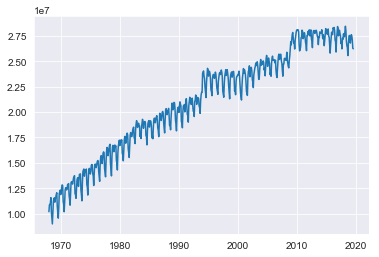

In [70]:
plt.plot(full_df['Part_time_emp'])

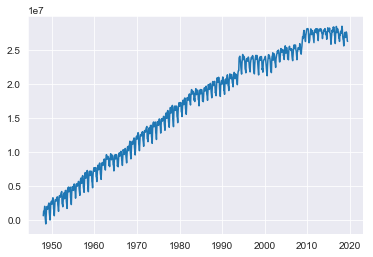

In [137]:
temp_series = full_df['Part_time_emp'] - full_df['Part_time_emp'].shift(-240)
temp_series = temp_series.interpolate(method='time', limit_direction='backward') + full_df['Part_time_emp'].shift(-240)
temp_series = temp_series[temp_series.index.year < 1968]
interpolated_part_time = temp_series.append(full_df[full_df.index.year >= 1968]['Part_time_emp'])

full_df['Part_time_emp'] = interpolated_part_time
plt.plot(full_df['Part_time_emp'])

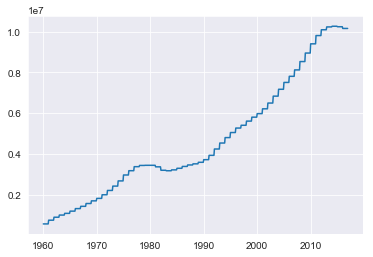

In [71]:
plt.plot(full_df['SSA_disab'])

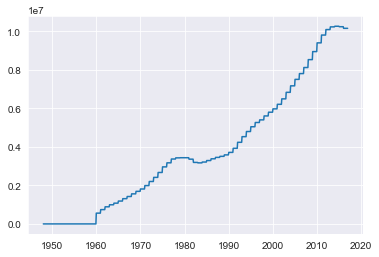

In [136]:
backfilled_ssa = full_df[full_df.index.year < 1960]['SSA_disab'].fillna(value=0)
full_df['SSA_disab'] = backfilled_ssa.append(full_df[full_df.index.year >= 1960]['SSA_disab'])

In [185]:
ssa_hard_values = full_df['SSA_disab'].dropna()
# cutoff = int(round(len(ssa_hard_values) * .8, 0))
train= ssa_hard_values[ssa_hard_values.index.year < 2016-12]
test = ssa_hard_values[ssa_hard_values.index.year >= 2016-12]
stepwise_model = pm.auto_arima(ssa_hard_values, start_p=0, start_q=0,
                             max_p=12, max_q=12,
                             seasonal=False,
                             start_d=0, max_d=12, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)
display(stepwise_model.summary())

Fit ARIMA: order=(0, 2, 0); AIC=21111.381, BIC=21120.817, Fit time=0.006 seconds
Fit ARIMA: order=(1, 2, 0); AIC=20875.755, BIC=20889.909, Fit time=0.019 seconds
Fit ARIMA: order=(0, 2, 1); AIC=20504.544, BIC=20518.698, Fit time=0.071 seconds
Fit ARIMA: order=(1, 2, 1); AIC=20504.357, BIC=20523.228, Fit time=0.249 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 2); AIC=20443.865, BIC=20472.171, Fit time=0.310 seconds
Fit ARIMA: order=(3, 2, 2); AIC=20475.118, BIC=20508.143, Fit time=0.794 seconds
Fit ARIMA: order=(2, 2, 1); AIC=20503.909, BIC=20527.498, Fit time=0.309 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 3); AIC=20415.553, BIC=20453.295, Fit time=0.663 seconds
Fit ARIMA: order=(4, 2, 3); AIC=20415.249, BIC=20457.710, Fit time=0.764 seconds
Fit ARIMA: order=(4, 2, 2); AIC=20427.240, BIC=20464.983, Fit time=0.571 seconds
Fit ARIMA: order=(4, 2, 4); AIC=20394.489, BIC=20441.667

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  827
Model:                 ARIMA(6, 2, 4)   Log Likelihood              -10165.037
Method:                       css-mle   S.D. of innovations          52529.827
Date:                Wed, 04 Sep 2019   AIC                          20354.074
Time:                        12:22:31   BIC                          20410.687
Sample:                             2   HQIC                         20375.788
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6200     88.608     -0.075      0.940    -180.288     167.048
ar.L1.D2.y    -0.7412      0.046    -16.245      0.000      -0.831      -0.652
ar.L2.D2.y     0.0888      0.055      1.626      0.104      -0.018       0.196
ar.L3.D2.y     0.4400      0.048      9.104      0.000       0.345       0.535
ar.L4.D2.y    -0.1825      0.046     -3.945      0.000      -0.273      -0.092
ar.L5.D2.y    -0.2286      0.048     -4.755      0.000      -0.323      -0.134
ar.L6.D2.y    -0.2686      0.037     -7.207      0.000      -0.342      -0.196
ma.L1.D2.y    -0.3424      0.037     -9.171      0.000      -0.416      -0.269
ma.L2.D2.y    -0.9612      0.054    -17.686      0.000      -1.068      -0.855
ma.L3.D2.y    -0.3762      0.033    -11.565      0.000      -0.440      -0.312
ma.L4.D2.y     0.7711      0.026     29.775      0.000       0.720       0.822
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0529           -0.6415j            1.2329           -0.0871
AR.2            1.0529           +0.6415j            1.2329            0.0871
AR.3           -0.8971           -0.5682j            1.0619           -0.4101
AR.4           -0.8971           +0.5682j            1.0619            0.4101
AR.5           -0.5812           -1.3543j            1.4737           -0.3145
AR.6           -0.5812           +1.3543j            1.4737            0.3145
MA.1           -0.8247           -0.6555j            1.0534           -0.3931
MA.2           -0.8247           +0.6555j            1.0534            0.3931
MA.3            1.0686           -0.1636j            1.0811           -0.0242
MA.4            1.0686           +0.1636j            1.0811            0.0242
-----------------------------------------------------------------------------
"""

In [186]:
stepwise_model.fit(train)
yhat = stepwise_model.predict(n_periods=13*12+1)

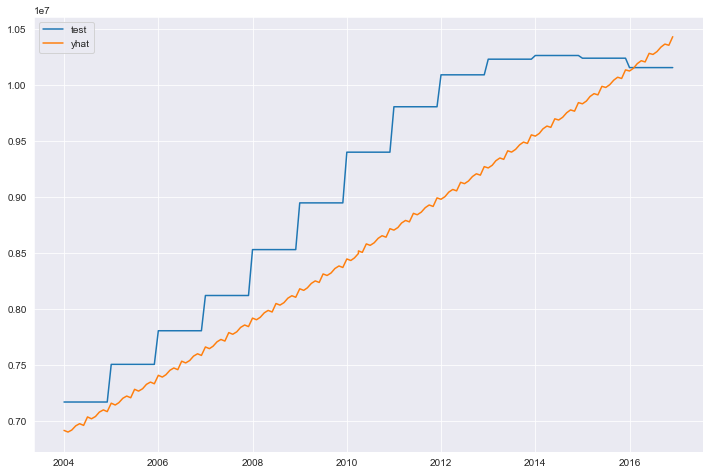

In [187]:
yhat_series = pd.Series(index=test.index, data=yhat)
plt.figure(figsize=(12,8))
plt.plot(test, label='test')
plt.plot(yhat_series, label='yhat')
plt.legend()

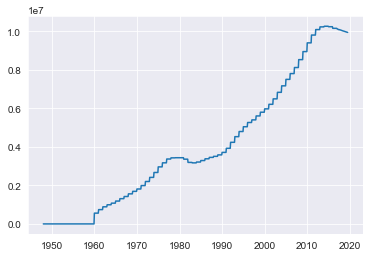

In [192]:
stepwise_model.fit(ssa_hard_values)
yhat_2 = stepwise_model.predict(n_periods=31)
yhat_2_series = pd.Series(index=full_df.index[full_df['SSA_disab'].isna()], data=yhat_2)

arima_ssa = ssa_hard_values.append(yhat_2_series)
plt.plot(arima_ssa)

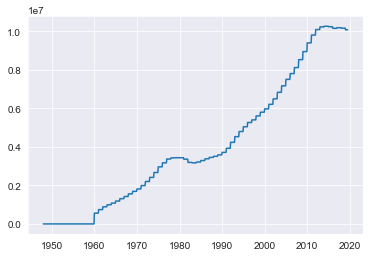

In [138]:
temp_series = full_df['SSA_disab'] - full_df['SSA_disab'].shift(36)
temp_series = temp_series.interpolate(method='time', limit_direction='forward') + full_df['SSA_disab'].shift(36)
temp_series = temp_series[temp_series.index.year > 2016]
interpolated_ssa = full_df[full_df.index.year <= 2016]['SSA_disab'].append(temp_series)

plt.plot(interpolated_ssa)

In [193]:
full_df['SSA_disab'] = interpolated_ssa

In [198]:
full_df.index[full_df['Age_55-64_work_%'].isna()]

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01',
               '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01',
               '1959-11-01', '1959-12-01'],
              dtype='datetime64[ns]', length=144, freq=None)

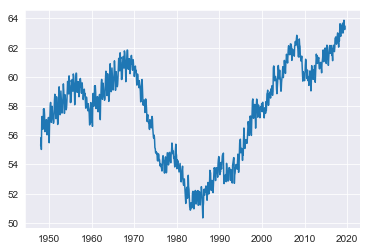

In [199]:
temp_series = full_df['Age_55-64_work_%'] - full_df['Age_55-64_work_%'].shift(-144)
temp_series = temp_series.interpolate(method='time', limit_direction='backward') + full_df['Age_55-64_work_%'].shift(-144)
temp_series = temp_series[temp_series.index.year < 1960]
interpolated_55_64 = temp_series.append(full_df[full_df.index.year >= 1960]['Age_55-64_work_%'])

plt.plot(interpolated_55_64)

In [200]:
full_df['Age_55-64_work_%'] = interpolated_55_64

In [202]:
full_df['Part_time_%'] = full_df['Part_time_emp'] / full_df['Working_age_pop']

In [203]:
full_df['SSA_disab_%'] = full_df['SSA_disab'] / full_df['Working_age_pop']

In [205]:
full_and_part_time = pd.read_csv('Season_no/Employees - Full and Part Time no season.csv')
full_and_part_time.columns = ['Date', 'Full_and_part_time']
full_and_part_time['Date'] = pd.to_datetime(full_and_part_time.Date)
full_and_part_time['Full_and_part_time'] = full_and_part_time['Full_and_part_time'] * 1000
full_and_part_time

,Date,Full_and_part_time
0,1929-01-01,37699000.0
1,1930-01-01,35590000.0
2,1931-01-01,32724000.0
3,1932-01-01,29445000.0
4,1933-01-01,30940000.0
5,1934-01-01,34238000.0
6,1935-01-01,35577000.0
7,1936-01-01,38599000.0
8,1937-01-01,39701000.0
9,1938-01-01,38322000.0


In [ ]:
full_df['New_Employment_Metric'] = (full_df['Age'])

In [201]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 860 entries, 1948-01-01 to 2019-07-01
Data columns (total 40 columns):
Age_16-19_pop                              860 non-null int64
Age_20-24_pop                              860 non-null int64
Age_25-34_pop                              860 non-null int64
Age_35-44_pop                              860 non-null int64
Age_45-54_pop                              860 non-null int64
Age_55-64_pop                              860 non-null int64
Working_age_pop                            860 non-null int64
Agriculture_emp                            860 non-null float64
Construction_emp                           860 non-null float64
Education_Health_emp                       860 non-null float64
Finance_emp                                860 non-null float64
Leisure_Hospitality_emp                    860 non-null float64
Manufacturing_emp                          860 non-null float64
Mining_Logging_emp                         860 non-null fl

### Analysis

Calc rolling mean for all percentages?

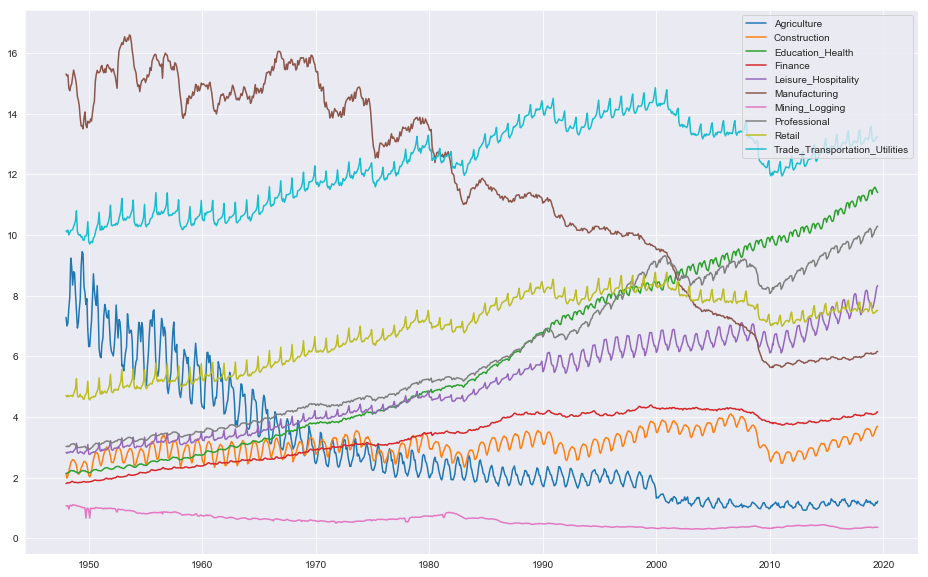

In [66]:
plt.figure(figsize=(16,10))
for industry in industries:
    plt.plot(full_df['{}_%_of_pop'.format(industry)], label=industry)
plt.legend()
plt.show()

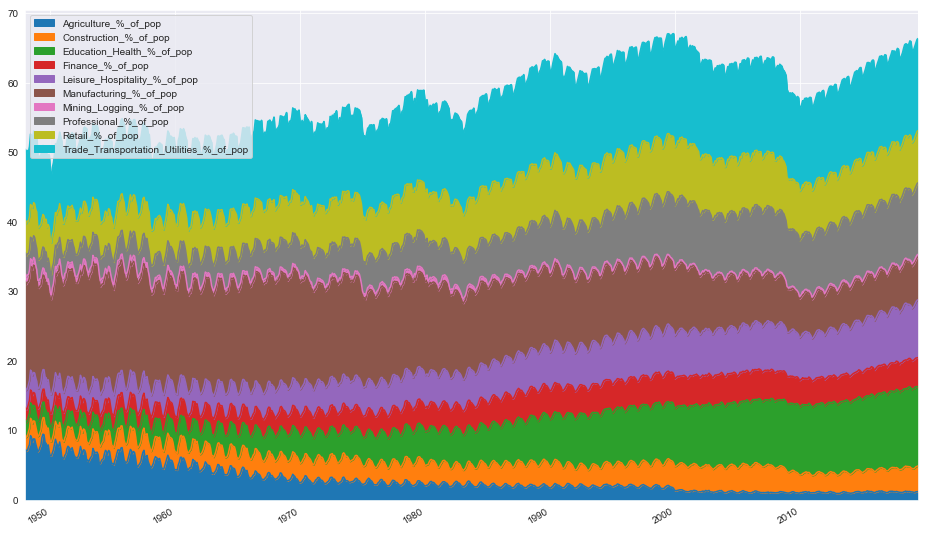

In [67]:
full_df[['Agriculture_%_of_pop',
         'Construction_%_of_pop',
         'Education_Health_%_of_pop',
         'Finance_%_of_pop',
         'Leisure_Hospitality_%_of_pop',
         'Manufacturing_%_of_pop',
         'Mining_Logging_%_of_pop',
         'Professional_%_of_pop',
         'Retail_%_of_pop',
         'Trade_Transportation_Utilities_%_of_pop']].plot.area(figsize=(16,10))

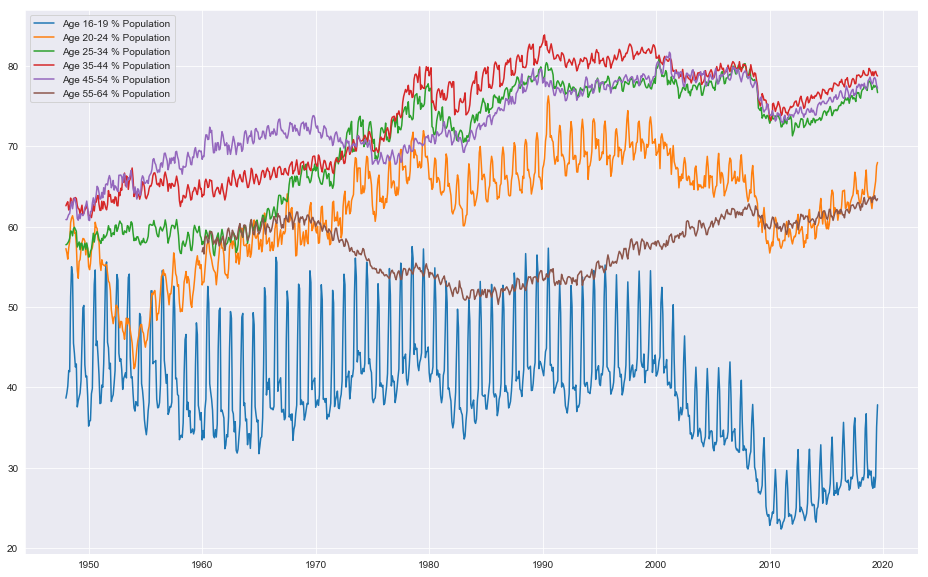

In [69]:
plt.figure(figsize=(16,10))
for age in emp_levels:
    plt.plot(full_df['Age_{}_work_%'.format(age)], label='Age {} % Population'.format(age))
plt.plot(full_df['Age_55-64_work_%'], label='Age 55-64 % Population')
plt.legend()
plt.show()